In [1]:
import pandas as pd
sopr_df = pd.read_excel('./data/SOPR 비율 (장기 보유자 SOPR.xlsx')

In [2]:
date_list = ['2020-12-17','2021-01-06','2021-02-08','2021-02-25','2021-05-14',
             '2021-05-19','2021-06-21','2021-07-27','2022-01-22','2022-05-09',
             '2022-06-13','2022-11-09','2023-01-14','2023-03-14']

In [3]:
sopr_df['날짜'] = pd.to_datetime(sopr_df['날짜'], format = "%Y %m %d")
sopr_df['가격'] = sopr_df['가격'].str.replace(',', '').astype(float)
sopr_df['가격'] = pd.to_numeric(sopr_df['가격'], errors='coerce')
new_columns = {'날짜':'DATE','가격':'PRICE','SOPR 비율 (장기 보유자 SOPR/단기 보유자 SOPR)':'SOPR_RATE'}
sopr_df = sopr_df.rename(columns=new_columns)

In [4]:
df_interval = pd.read_excel('./data/변동성_구간.xlsx')

In [5]:
sopr_df.describe()

,DATE,PRICE,SOPR_RATE
count,1094,1090.000000,1094.000000
mean,2022-03-20 12:00:00,33029.285833,2.027142
min,2020-09-20 00:00:00,10254.615670,0.352418
25%,2021-06-20 06:00:00,21581.789135,0.835071
50%,2022-03-20 12:00:00,29759.458660,1.373750
75%,2022-12-18 18:00:00,42983.579859,2.293235
max,2023-09-18 00:00:00,67551.341640,12.847941
std,NaN,13647.655726,1.876780


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import DBSCAN

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context('talk')

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sopr_df[['scaled_SOPR_RATE']] = scaler.fit_transform(sopr_df[['SOPR_RATE']])
X = sopr_df[['scaled_SOPR_RATE']].values

In [11]:
eps = [i*(1/100) for i in range(2,11)]
eps

[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

In [8]:
dbscan = DBSCAN(eps=0.1, min_samples=20).fit(X)

In [9]:
labels = dbscan.labels_
pd.Series(labels).value_counts()

 0    1089
-1       5
Name: count, dtype: int64

In [10]:
sopr_df['label'] = labels

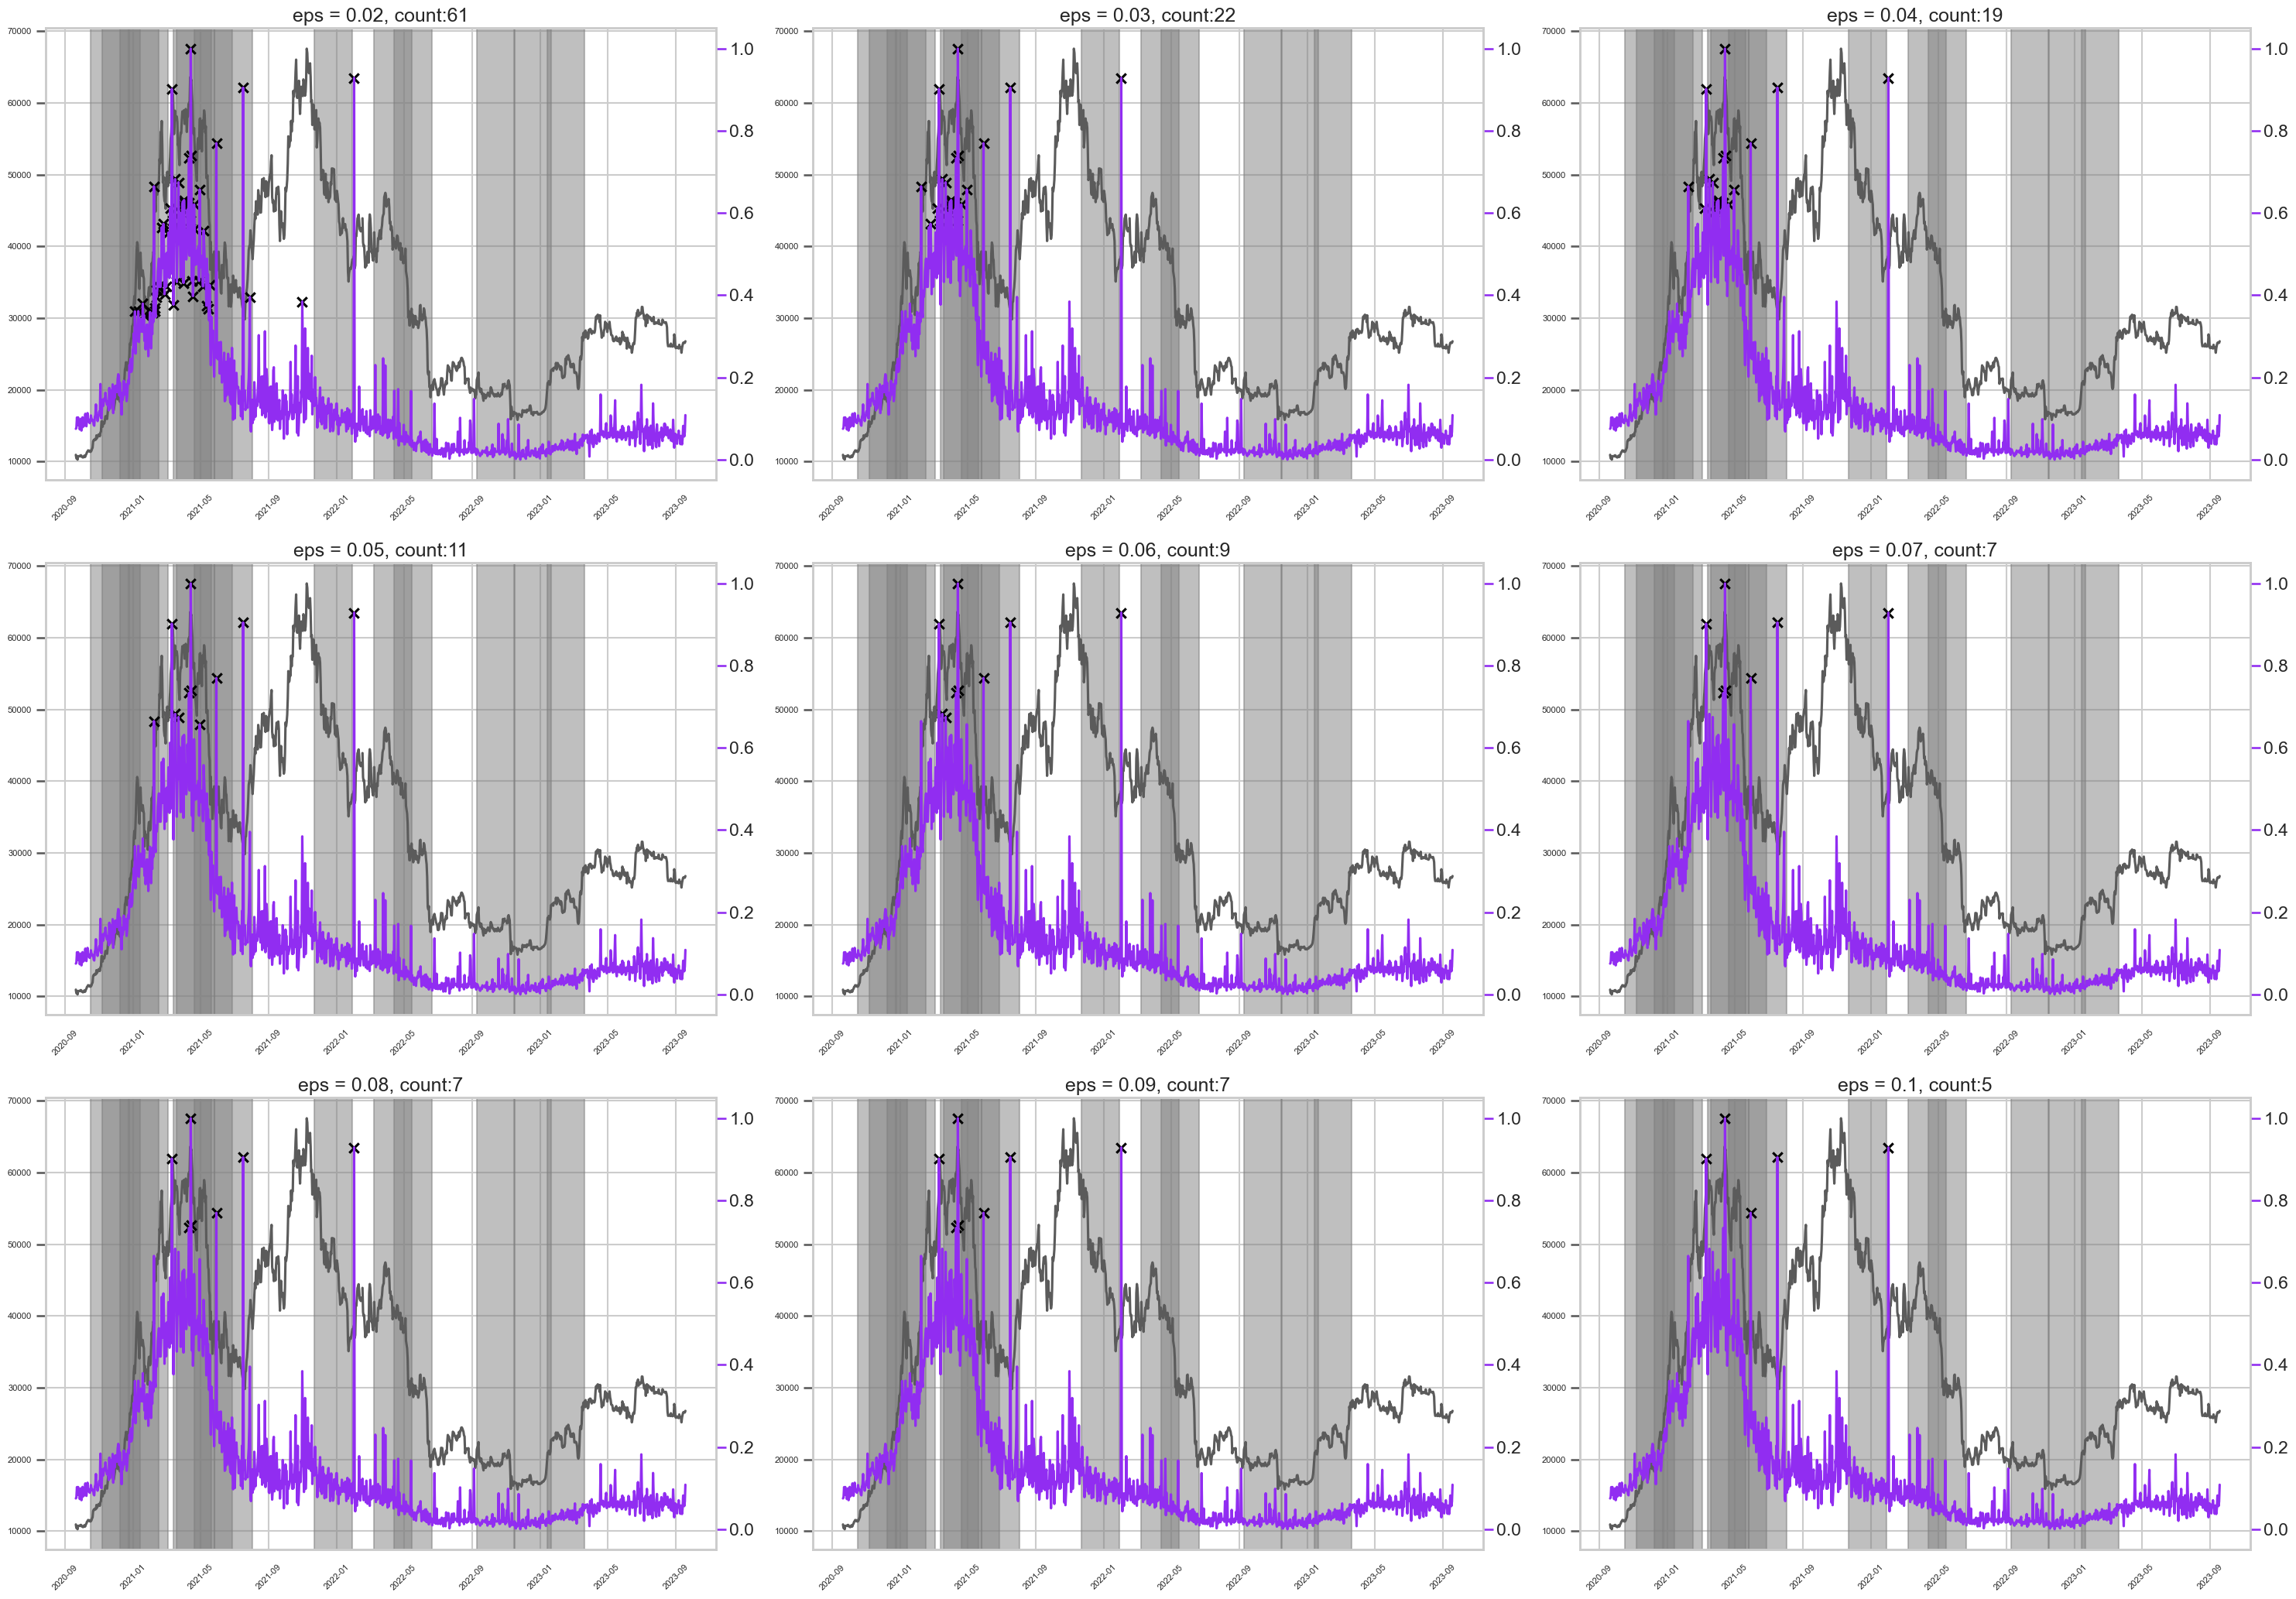

In [13]:
from datetime import datetime, timedelta
fig, axs = plt.subplots(3, 3, figsize=(30, 21))


for i in range(3):
    for j in range(3):
        ax1 = axs[i][j]

        # DBSCAN 모델 생성 및 학습
        model = DBSCAN(eps=eps[i * 3 + j], min_samples=20)
        model.fit(X)
        labels = model.labels_
        sopr_df['label'] = labels
        # 첫 번째 y축 그래프 (가격)
        ax1.plot(sopr_df['DATE'], sopr_df['PRICE'], label='price',color='#5b5b5b')
        # ax1.set_xlabel('DATE')
        # ax1.set_ylabel('PRICE',color='#5b5b5b')
        ax1.tick_params(axis='y',color='#5b5b5b')
        # ax1.legend(loc='upper left')
        ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
        ax1.tick_params(axis='y', labelsize=8)
        # 두 번째 y축 그래프 (CDD)
        ax2 = ax1.twinx()
        ax2.plot(sopr_df['DATE'], sopr_df['scaled_SOPR_RATE'], label='CDD',color='#912df1')
        # ax2.set_ylabel('CDD',color='#912df1')
        ax2.tick_params(axis='y',color='#912df1')

        # 이상치 표시
        label_minus_1 = sopr_df[sopr_df['label'] == -1]
        ax2.scatter(label_minus_1['DATE'], label_minus_1['scaled_SOPR_RATE'], marker='x', color='black', label='CDD (-1)')

        # 구간 표시
        for index, row in df_interval.iterrows():
            start_date = row['start_date']
            end_date = row['end_date']
            ax1.axvspan(start_date, end_date, color='gray', alpha=0.5)

        # 그래프의 제목에 파라미터 값 추가
        ax1.set_title(f'eps = {eps[i * 3 + j]}, count:{len(label_minus_1)}')
        plt.grid(False)
fig.tight_layout()
plt.show()

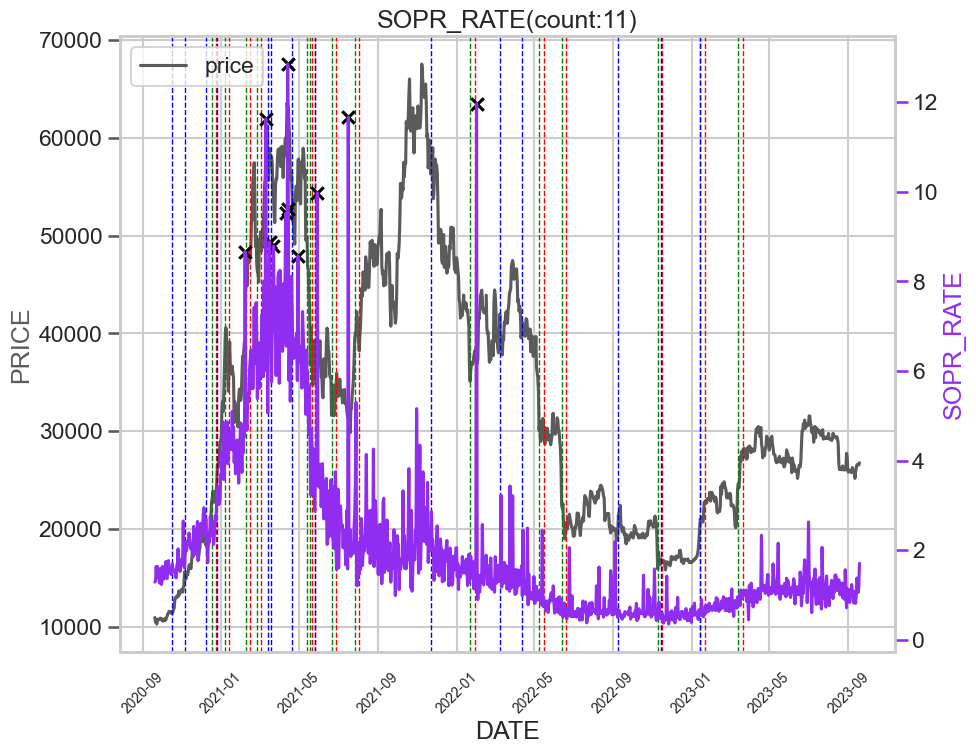

In [28]:
from datetime import datetime, timedelta


fig, ax1 = plt.subplots(figsize=(10, 8))

# 첫 번째 y축 그래프 (가격)
ax1.plot(sopr_df['DATE'], sopr_df['PRICE'], label='price',color='#5b5b5b')
ax1.set_xlabel('DATE')
ax1.set_ylabel('PRICE',color='#5b5b5b')
ax1.tick_params(axis='y',color='#5b5b5b')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', labelrotation=45, labelsize=10)
# 두 번째 y축 그래프 (CDD)
ax2 = ax1.twinx()
ax2.plot(sopr_df['DATE'], sopr_df['SOPR_RATE'], label='SOPR_RATE',color='#912df1')
ax2.set_ylabel('SOPR_RATE',color='#912df1')
ax2.tick_params(axis='y',color='#912df1')
# ax2.legend(loc='upper right')


label_minus_1 = sopr_df[sopr_df['label'] == -1]
ax2.scatter(label_minus_1['DATE'], label_minus_1['SOPR_RATE'], marker='x', color='black', label='SOPR_RATE (-1)')

# 그래프 제목 설정
plt.title('SOPR_RATE(count:11)')
plt.xticks(fontsize=10, rotation=45)
plt.grid(False)


for date in date_list:
    target_date = pd.to_datetime(date)  # 날짜 문자열을 datetime으로 변환
    ax1.axvline(x=target_date, color='green', linestyle='--', linewidth=1)
    
    # '일자로부터 두 달 전'을 계산하여 세로선 그리기
    two_months_ago = target_date - pd.DateOffset(months=2)
    ax1.axvline(x=two_months_ago, color='blue', linestyle='--', linewidth=1)
    
    # '일자로부터 일주일 후'를 계산하여 세로선 그리기
    one_week_later = target_date + timedelta(weeks=1)
    ax1.axvline(x=one_week_later, color='red', linestyle='--', linewidth=1)
# 그래프 표시
plt.show()

In [29]:
sopr_df[sopr_df['label'] == -1]

,DATE,PRICE,SOPR_RATE,label
140,2021-02-07,38848.870841,8.662044,-1
172,2021-03-11,57826.773426,11.623337,-1
178,2021-03-17,58896.711841,8.880493,-1
184,2021-03-23,54342.991556,8.785121,-1
203,2021-04-11,59994.790880,9.516032,-1
206,2021-04-14,62946.338434,12.847941,-1
207,2021-04-15,63220.438802,9.605708,-1
222,2021-04-30,57733.903976,8.565834,-1
252,2021-05-30,NaN,9.973578,-1
300,2021-07-17,31544.077167,11.662605,-1
